In [1]:
import numpy as np
from keras import layers
import keras
from keras import layers
import model as md
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense

%matplotlib inline
import matplotlib
matplotlib.use('tkagg')
import matplotlib.pyplot as plt
plt.gray()
# import matplotlib as mpl
# mpl.use('tkagg')

# CuDNN新しすぎ？
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Using TensorFlow backend.


In [2]:
import keras
from keras import layers

def VAE(latent_size, kl_coeff=1.0):
    
    ## Encoder #################################################################################
    encoder_input = keras.Input(shape=(128,128,1) )
    x = layers.Conv2D(16,4,padding='same',activation='relu',strides=(2,2))(encoder_input)
    x = layers.Conv2D(32,4,padding='same',activation='relu',strides=(2,2))(x)
    x = layers.Conv2D(48,4,padding='same',activation='relu',strides=(2,2))(x)
    x = layers.Conv2D(64,4,padding='same',activation='relu',strides=(2,2))(x)
    shape_before_flattening = K.int_shape(x) # フラット前の構造を保存
    
    x = layers.Flatten()(x)
    x = layers.Dense(latent_size, activation='relu')(x)
    
    z_mean = layers.Dense(latent_dim,name='z_mean')(x)
    z_log_sigma = layers.Dense(latent_dim)(x)
    
    ## Latent Dim Sampling
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim) , mean = 0 , stddev=1. )
        return z_mean + K.exp(z_log_sigma) * epsilon
        
    encoder = Model(encoder_input,z_mean, name='encoder') # z_mean is neccesary not z
    encoder.summary()
    ############################################################################################

    ## Decoder #################################################################################
    z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    decoder_input = layers.Input(K.int_shape(z)[1:])
    x = layers.Dense(np.prod(shape_before_flattening[1:]),activation='relu')(decoder_input)
    x = layers.Reshape(shape_before_flattening[1:])(x)
    x = layers.Conv2DTranspose(64,4,padding='same',activation='relu',strides=(2,2) )(x)
    x = layers.Conv2DTranspose(48,4,padding='same',activation='relu',strides=(2,2) )(x)
    x = layers.Conv2DTranspose(32,4,padding='same',activation='relu',strides=(2,2) )(x)
    x = layers.Conv2DTranspose(16,4,padding='same',activation='relu',strides=(2,2) )(x)
    x = layers.Conv2D(1,3,padding='same',activation='sigmoid')(x)
    decoder = Model(decoder_input,x)
    decoder.summary()
    ############################################################################################
    
    # define VAE
    z_decoded = decoder(z_mean)
    vae = Model(encoder_input,z_decoded)
    vae.summary()
        
    def vae_loss(y_true, y_pred):
        
        recon_loss = K.sum(K.square(y_true-y_pred), axis=[1,2])
        kl_loss = - 0.5 * K.sum(1 + 2*z_log_sigma - K.square(z_mean) - K.square(K.exp(z_log_sigma)), axis=-1)
        return recon_loss + kl_coeff*kl_loss
    
    return encoder, decoder, vae, vae_loss

In [3]:
latent_dim = 128
# model定義
encoder, decoder, vae, vae_loss = VAE(latent_dim, kl_coeff=1.)

W0809 00:17:24.275103 140652739282688 deprecation_wrapper.py:119] From /home/sk/dev/anaconda3/envs/sk/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 00:17:24.275715 140652739282688 deprecation_wrapper.py:119] From /home/sk/dev/anaconda3/envs/sk/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 00:17:24.277453 140652739282688 deprecation_wrapper.py:119] From /home/sk/dev/anaconda3/envs/sk/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 00:17:24.341050 140652739282688 deprecation_wrapper.py:119] From /home/sk/dev/anaconda3/envs/sk/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        272       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        8224      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 48)        24624     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          49216     
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               524416    
__________

In [4]:
vae.compile(optimizer='adam', loss=vae_loss, metrics=[])

data_OK = np.load("./data/ok.npy")
data_NG = np.load("./data/ng.npy")

# scaling 0 to 1
data_OK = data_OK.astype('float32') / 255.
#data_OK = data_OK.transpose(0,2,3,1) # transpose

data_NG = data_NG.astype('float32') / 255.
#data_NG = data_NG.transpose(0,2,3,1) # transpose

# train, test split
n_train = int(data_OK.shape[0]*0.6)
X_train = data_OK[0:n_train:]

n_val = int(data_OK.shape[0]*0.2)
X_val_OK  = data_OK[n_train:n_train+n_val:]
X_test_OK = data_OK[n_train+n_val::]

# n_test = int( len(data_NG)*0.6 )
X_test_NG  = data_NG[:]


print("OK sample shape",data_OK.shape)
print("X_train.shape", X_train.shape)
print("X_test_OK.shape", X_test_OK.shape)
print("X_val_OK.shape",X_val_OK.shape)
print("X_test_NG.shape",X_test_NG.shape)

W0809 00:17:24.473363 140652739282688 deprecation_wrapper.py:119] From /home/sk/dev/anaconda3/envs/sk/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



OK sample shape (1000, 128, 128, 1)
X_train.shape (600, 128, 128, 1)
X_test_OK.shape (200, 128, 128, 1)
X_val_OK.shape (200, 128, 128, 1)
X_test_NG.shape (150, 128, 128, 1)


In [5]:
from keras.preprocessing.image import ImageDataGenerator

# datagen= ImageDataGenerator(
#     #featurewise_center=True,
#     #featurewise_std_normalization=True
#     rotation_range=3, # 90°まで回転
#     width_shift_range=0.05, # 水平方向にランダムでシフト
#     #height_shift_range=0.1, # 垂直方向にランダムでシフト
#     #channel_shift_range=50.0, # 色調をランダム変更
#     #shear_range=0.39, # 斜め方向(pi/8まで)に引っ張る
#     horizontal_flip=True) # 水平方向にランダムで反転

datagen= ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True
    rotation_range=90, # 90°まで回転
    #width_shift_range=0.4,# 水平方向にランダムでシフト
    #height_shift_range=0.4, #垂直方向にランダムでシフト
    #channel_shift_range=50.0, # 色調をランダム変更
    #shear_range=0.39, # 斜め方向(pi/8まで)に引っ張る
    horizontal_flip=True) # 水平方向にランダムで反転


datagen.fit(X_train)


_train_size = X_train.shape[0]
_batch_size = 16
_itr_size = 2000

print('trainin_data : %d \
      \nbatch_size   : %d \
      \niter_size : %d \
      \nvirtual_epoch : % d ' % (_train_size, _batch_size, _itr_size, _itr_size / (_train_size / _batch_size)))


trainin_data : 600       
batch_size   : 16       
iter_size : 500       
virtual_epoch :  13 


In [6]:
itr=0
train_loss_running,val_loss_running=0,0
train_loss, val_loss = [],[]

val_judge = float('inf') # oneday change this
# infinite loop, so break using virtural epoch
for x_batch in datagen.flow(x=X_train, y=None, batch_size=32,shuffle=True):
    
    # train using one bathc
    result = vae.fit(x = x_batch, y=x_batch , verbose=0,validation_data=(X_val_OK,X_val_OK))
    
    # caluculate train_loss and val_loss
    val_loss_running = result.history['val_loss'][0] / _batch_size
    train_loss.append( result.history['loss'][0] / _batch_size)
    val_loss.append( val_loss_running )

    # best_model save after 80% train loop
    if val_loss_running < val_judge and int(0.9* _itr_size) < itr:
        
        print(" model save, val_loss :", val_loss_running)
        val_judge = val_loss_running        
        encoder.save('./data/encoder_best.h5',include_optimizer=False)
        decoder.save('./data/decoder_best.h5',include_optimizer=False)
    
    
    if itr % 100== 0:
        print('-------------iteration-------------', itr)
    if itr > _itr_size:
        break
        
    itr = itr+1

W0809 00:17:24.721059 140652739282688 deprecation_wrapper.py:119] From /home/sk/dev/anaconda3/envs/sk/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



-------------iteration------------- 0
-------------iteration------------- 100
-------------iteration------------- 200
-------------iteration------------- 300
-------------iteration------------- 400
 model save, val_loss : 2.5461358070373534
 model save, val_loss : 2.5412006855010985
 model save, val_loss : 2.528733425140381
 model save, val_loss : 2.5238895988464356
 model save, val_loss : 2.5074767017364503
 model save, val_loss : 2.5016016387939453
-------------iteration------------- 500


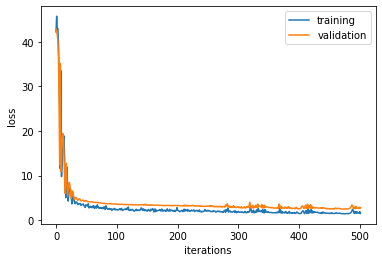

In [7]:
# load best model
encoder_best = keras.models.load_model('./data/encoder_best.h5', compile=False)
decoder_best = keras.models.load_model('./data/decoder_best.h5', compile=False)

# encode and decode
encode_test_OK = encoder_best.predict(X_test_OK)
decode_test_OK = decoder_best.predict(encode_test_OK)
encode_test_NG = encoder_best.predict(X_test_NG)
decode_test_NG = decoder_best.predict(encode_test_NG)

# plot loss and acc
plt.plot( train_loss, label="training")
plt.plot( val_loss, label="validation")
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
plt.show()

In [8]:
## Mean Absolute Error
# OK
arr_mae_OK = []
diff_OK = (X_test_OK - decode_test_OK)
diff_OK = np.absolute(diff_OK)
for i in range(len(diff_OK)):
    arr_mae_OK.append(np.sum(diff_OK[i,:,:,0] / diff_OK[i,:,:,0].size ))

# NG
arr_mae_NG = []
diff_NG = (X_test_NG - decode_test_NG)
diff_NG = np.absolute(diff_NG)
for i in range(len(diff_NG)):
    #print(np.sum(diff_NG[i,:,:,0]) , diff_NG[i,:,:,0].size )
    arr_mae_NG.append(np.sum(diff_NG[i,:,:,0] / diff_NG[i,:,:,0].size ))
    
print(diff_OK[0,:,:,0].size)
print(diff_NG[0,:,:,0].size)
print(128*128)

print( len(arr_mae_OK) )
print( len(arr_mae_NG) )
th = np.min(arr_mae_NG)
print(th,np.max(arr_mae_OK))


16384
16384
16384
200
150
0.032278426 0.039475918


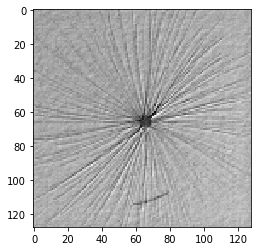

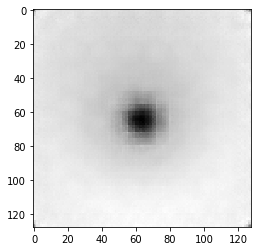

In [9]:
plt.imshow( X_test_NG[10,:,:,0] )
plt.show()
plt.imshow( decode_test_NG[10,:,:,0] )

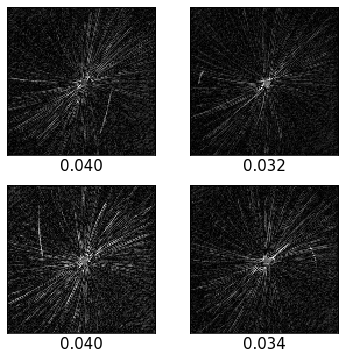

In [10]:
fig = plt.figure(figsize=(6.0, 6.0))

row,col = 2,2
id_res = 1
for r in range(0,row):
    for c in range(0,col):
        ax = fig.add_subplot(row,col ,id_res)
        ax.imshow( diff_NG[id_res,:,:,0] )
        ax.tick_params(labelbottom=False, labelleft=False, direction='in')
        mae = np.sum( diff_NG[id_res,:,:,0]) / diff_NG[id_res,:,:,0].size
        ax.set_xlabel( '{:.3f}'.format(mae),size=15)
        id_res = id_res + 1 # 画像ID
plt.show()
#plt.savefig('res_diff.png', facecolor='#cccccc')
plt.close()

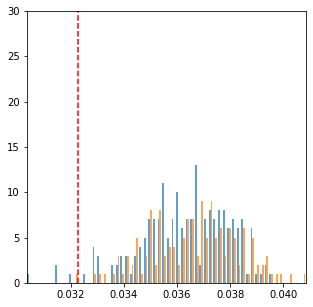

In [11]:


plt.figure(figsize=(5,5))
plt.hist([arr_mae_OK,arr_mae_NG], bins=60, alpha=0.7 )
xmin = 0; xmax = 30
plt.vlines([th], xmin, xmax, "blue", linestyles='dashed',color='red')
mean = np.mean(arr_mae_OK)
std = np.std(arr_mae_OK)
lower = np.min(arr_mae_OK)
upper = np.max(arr_mae_NG)
plt.xlim([lower,upper]); plt.ylim([0,30])
plt.show()

(128, 128)
float32
data_katagawa.shape (600, 128, 128, 1)
(600, 128, 128, 1)


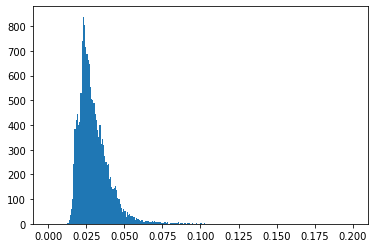

float64


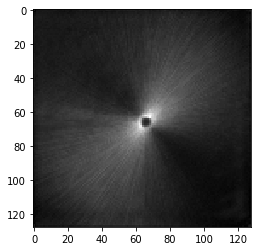

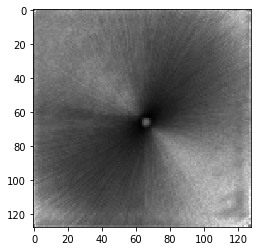

In [12]:


# for i in range(len(X_test_NG)):
#     plt.imsave("./data/res/input/input"+str(i)+".png",X_test_NG[i,:,:,0])
#     plt.imsave("./data/res/decode/"+str(i)+".png",decode_test_NG[i,:,:,0])
#     plt.imsave("./data/res/diff/"+str(i)+".png",diff_NG[i,:,:,0])

resimg = diff_NG[5,:,:,0]


orgimg = X_test_NG[5,:,:,0]
orgimg = orgimg * 255

print(resimg.shape)
print(resimg.dtype)

## 逆転画像を入力しているので，背景の分散が増す．

# Data load
# data_katagawa = np.load("./data/capsule_OK_katahou.npy")
# # Rescale -1 to 1
# data_katagawa = data_katagawa.astype('float32') / 255.
# data_katagawa = data_katagawa.transpose(0,2,3,1) # transpose

data_katagawa = X_train

print("data_katagawa.shape", data_katagawa.shape)

encode_katagawa = encoder.predict(data_katagawa)
decode_katagawa = decoder.predict(encode_katagawa)

diff_katagawa = (data_katagawa - decode_katagawa)
diff_katagawa = np.absolute(diff_katagawa)

print(diff_katagawa.shape)

std_img = np.zeros( (128,128) ,dtype=float)
mean_img = np.zeros( (128,128) ,dtype=float)
like_img = np.zeros( (128,128) ,dtype=float)

# 分散画像作成
for y in range(diff_katagawa.shape[1]):
    for x in range(diff_katagawa.shape[2]):        
        std,mean = np.std( diff_katagawa[:,y,x,0] ),np.mean( diff_katagawa[:,y,x,0] )
        std_img[y,x] = std
        mean_img[y,x] = mean
        like_img[y,x] = np.exp(-(x - mean)**2 / (2*std**2))

plt.hist(std_img.ravel(),256,[0,0.2]); plt.show()        

print(std_img.dtype)

log_img = std_img.copy()
log_img[:,:] = 1.0 / std_img[:,:]
#log_img = like_img
plt.imshow(std_img); plt.show()
plt.imshow(log_img);plt.show()

79.1945631439747


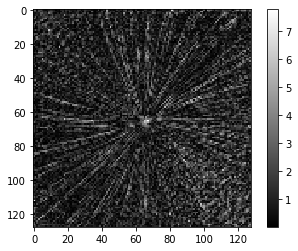

20922.42796840563
200
150
1.0879952907562256


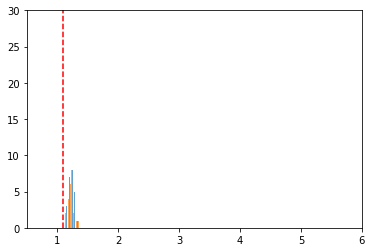

In [13]:


print(np.max(log_img))
#plt.hist(log_img.ravel(),256,[0,100]); plt.show()        

res_ok  = log_img * diff_OK[5,:,:,0]
res_ng  = log_img * diff_NG[5,:,:,0]

plt.imshow(res_ok); plt.colorbar(); plt.show()
print(np.sum(res_ok))

arr_mae_OK = []
log_OK = diff_OK.copy()
for i in range(len(diff_OK)):
    log_OK[i,:,:,0] = log_img * diff_OK[i,:,:,0]
    mae = np.sum(log_OK[i,:,:,0]) / log_OK[i,:,:,0].size
    arr_mae_OK.append(mae)


arr_mae_NG = []
log_NG = diff_NG.copy()
for i in range(len(diff_NG)):
    log_NG[i,:,:,0] = log_img * diff_NG[i,:,:,0]
    mae = np.sum(log_NG[i,:,:,0]) / log_NG[i,:,:,0].size
    arr_mae_NG.append(mae)
    
print( len(arr_mae_OK) )
print( len(arr_mae_NG) )

plt.hist([arr_mae_OK,arr_mae_NG], bins=60, alpha=0.7 )

th = np.min( np.array(arr_mae_NG) )
print(th)
ymin = 0; ymax = 100; plt.vlines([th], ymin, ymax, "blue", linestyles='dashed',color='red')
plt.xlim([0.5,6]); plt.ylim([0,30])
plt.show()

In [14]:
# combine ok and ng for making true and pred
pred = arr_mae_OK
pred = np.append(pred,arr_mae_NG)

true = np.zeros(np.array(arr_mae_OK).shape[0])
ones = np.ones(np.array(arr_mae_NG).shape[0])
true = np.append(true,ones)

from sklearn.metrics import roc_auc_score
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(true, pred)
auc = metrics.auc(fpr, tpr)

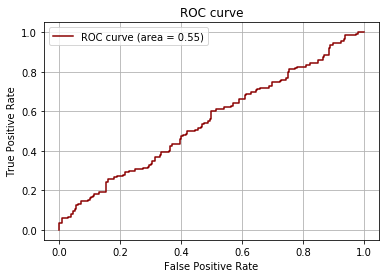

In [15]:
# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc ,color="darkred")
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

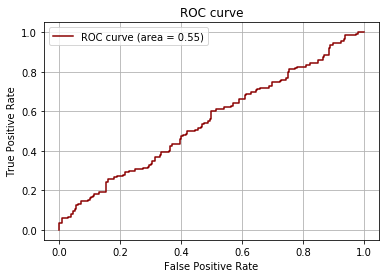

Confution Matrix:
[[150   0]
 [196   4]]
threshold:1.088
--------------------------------------------------------------------------
Accuracy:0.440
Recall:1.000 (recall must be 1.0)
Precision:0.434
F1-measure:0.605
--------------------------------------------------------------------------
未検出率(FNR):0.000 (must be 0.0)
過検出率(FPR):0.980
--------------------------------------------------------------------------


In [16]:


# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc ,color="darkred")
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

from sklearn.metrics import confusion_matrix

# しきい値以上を1
bin_pred = [1 if p >= th else 0 for p in pred]
m = confusion_matrix(true, bin_pred,labels=[1,0])
print('Confution Matrix:\n{}'.format(m))

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("threshold:{:.3f}".format(th))
print("--------------------------------------------------------------------------")
print('Accuracy:{:.3f}'.format(accuracy_score(true, bin_pred)))
print('Recall:{:.3f} (recall must be 1.0)'.format(recall_score(true, bin_pred)))
print('Precision:{:.3f}'.format(precision_score(true, bin_pred)))
print('F1-measure:{:.3f}'.format(f1_score(true, bin_pred)))
print("--------------------------------------------------------------------------")
print("未検出率(FNR):{:.3f} (must be 0.0)".format( m[0,1]/(m[0,1] + m[0,0]) ) )
print("過検出率(FPR):{:.3f}".format(m[1,0]/(m[1,0] + m[1,1])))
print("--------------------------------------------------------------------------")